In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import packages and formatting statements

import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os

plt.rc('text',usetex=False)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

In [3]:
# Compile galaxy and OSC objects
DataFile = '../Data/1.ProjectTable.csv'
Data = Table.read(DataFile, format='csv') 
galaxies, MUSEres, MUSEmaps = Data["Galaxy"], Data["MUSENatRes"], Data["MUSEmapNat"]
SNe = np.loadtxt('../Data/1.FullCatalog.csv', dtype = str, delimiter = ",",unpack=True, usecols = 0)
ras = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',', unpack = True, usecols=4)
decs = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',',unpack = True, usecols = (5))
types = np.loadtxt('../Data/1.FullCatalog.csv', dtype=str,delimiter=',', unpack=True, usecols=6)


In [4]:
#print(ESOmaps)

# types = [x.replace('',"Unclassified") for x in types]

# for i in range(len(types)):
#     print(types[i])


In [5]:
#Checks if Supernovae are in an image and reports back their x & y coords if in map

def check_in_image(SNras, SNdecs, SNnames, SNtypes, image):
    
    hdulist  = pyfits.open(image)
    
    map = hdulist["HA6562_FLUX"].data
    #emap = hdulist["HA6562_FLUX_ERR"].data     
    wcs = WCS(hdulist["HA6562_FLUX"].header, naxis=2)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist["HA6562_FLUX"].header['NAXIS1']
    naxis2 = hdulist["HA6562_FLUX"].header['NAXIS2']

        
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)

    is_in_x = (pix_x >= 0) & (pix_x <= naxis[0]-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis[1]-1)
             
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]
    
    return(name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2)
    #print(name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord)


In [6]:
# Build MUSE Catalogue That has all supernovae within PHANGS-MUSE footprint

with open('../Data/2.SNeHa_MUSE_Cat.txt', 'w') as text_file:
    print('#Galaxy,Supernova,Ra,Dec,MUSE_xCoord,MUSE_yCoord,Type,MUSE_Intensity,MUSE_map', file = text_file)

for i in range(len(galaxies)):
    if (MUSEmaps[i] != "" and os.path.isfile(MUSEmaps[i])):
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2 = check_in_image(ras, decs, SNe, types, MUSEmaps[i])
        intensity = []
    
        for k in range(len(found_type)):

            xVal = int(round(x_coord[k]))
            yVal = int(round(y_coord[k]))
            if (yVal <= naxis2) and (xVal <= naxis1):
                intensity.append(map[yVal, xVal])

            else: 
                intensity.append(np.nan)


        with open('../Data/2.SNeHa_MUSE_Cat.txt', 'a') as text_file:
            for j in range(len(found_name)):
                print(galaxies[i], ",", found_name[j],",", found_ra[j], ",",found_dec[j],",", x_coord[j],",",y_coord[j],",", found_type[j],",", intensity[j],",", MUSEmaps[i], file = text_file)


In [7]:
# Turn files into data structure and clean

MUSEdataFile = '../Data/2.SNeHa_MUSE_Cat.txt'
MUSETable = Table.read(MUSEdataFile, format='ascii') 
database = MUSETable # will use master catalog if we combine with ESO later
MUSETable

Galaxy,Supernova,Ra,Dec,MUSE_xCoord,MUSE_yCoord,Type,MUSE_Intensity,MUSE_map
str7,str11,float64,float64,float64,float64,str12,float64,str80
NGC0628,SN2013ej,24.200670833333334,15.758611111111112,243.11885674825174,305.29330284886476,II,nan,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits
NGC0628,SN2019krl,24.2067875,15.77946388888889,137.18487193542887,680.6496794953687,IIn/LBV,447.33069091690675,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits
NGC1087,SN1995V,41.61154166666667,-0.49878055555555556,182.8499455412301,450.8200411854245,II,2663.371834437333,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1087-0.92asec_MAPS.fits
NGC1365,SN1957C,53.38349999999999,-36.11770833333333,1004.4155369313344,865.6486483514018,Unclassified,1737.6042541521983,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits
NGC1365,SN1983V,53.38192083333333,-36.148580555555554,1027.2635595498382,309.94409754595245,II,5996.363596675533,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits
NGC1365,SN2001du,53.371249999999996,-36.142,1182.399513237841,428.35378352364773,IIP,771.0272731680817,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits
NGC1365,SN2012fr,53.39995833333333,-36.12713888888889,765.0991888576729,695.9235141161663,Ia,98.56839169106574,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits
NGC1433,SN1985P,55.526500000000006,-47.21,494.82229846949286,663.0629555201185,II,200.75143233198625,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1433-0.91asec_MAPS.fits
NGC1566,ASASSN-14ha,65.0058875,-54.93807777777778,408.4277260277734,443.3346781401191,II,2552.702982824482,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1566-0.80asec_MAPS.fits


In [8]:

SN_name = [x[2:-2] for x in database["Supernova"]]

# Here we are going to filter out our undesired OSC entries:
    # One is a double counted SN named "PTSS-19clju", any LRNs or LBVs, and any candidates

flags = []
flag1 = database['Supernova'] == "PTSS-19clju" 
flag3 = database['Supernova'] == "Gaia21fml" 
flag5 = database['Supernova'] == "Gaia21cum"

flag2 = []

for i in range(len(SN_name)):
    if ("LRN" in database['Type'][i] or "LBV" in database['Type'][i] or "Candidate" in database['Type'][i]):
        flag2.append(True)
    else:
        flag2.append(False)

for i in range(len(flag1)):
    if flag1[i] == True or flag2[i] == True or flag3[i] == True or flag5[i] == True:
        flags.append(True)
    else:
        flags.append(False)
        
flagsArr = np.array(flags)

c = Column(data=flags, name='Removed')
database.add_column(c)
ascii.write(database, '../Data/2.SNeHaMasterCat.csv', format='csv', fast_writer=False, overwrite = True) 

cleanData = database[flagsArr==False]

cleanData

ascii.write(cleanData, '../Data/2.SNeHaMasterCatClean.csv', format='csv', fast_writer=False, overwrite = True)  

In [9]:
cleanData

Galaxy,Supernova,Ra,Dec,MUSE_xCoord,MUSE_yCoord,Type,MUSE_Intensity,MUSE_map,Removed
str7,str11,float64,float64,float64,float64,str12,float64,str80,bool
NGC0628,SN2013ej,24.200670833333334,15.758611111111112,243.11885674825174,305.29330284886476,II,nan,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,False
NGC1087,SN1995V,41.61154166666667,-0.49878055555555556,182.8499455412301,450.8200411854245,II,2663.371834437333,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1087-0.92asec_MAPS.fits,False
NGC1365,SN1957C,53.38349999999999,-36.11770833333333,1004.4155369313344,865.6486483514018,Unclassified,1737.6042541521983,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,False
NGC1365,SN1983V,53.38192083333333,-36.148580555555554,1027.2635595498382,309.94409754595245,II,5996.363596675533,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,False
NGC1365,SN2001du,53.371249999999996,-36.142,1182.399513237841,428.35378352364773,IIP,771.0272731680817,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,False
NGC1365,SN2012fr,53.39995833333333,-36.12713888888889,765.0991888576729,695.9235141161663,Ia,98.56839169106574,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,False
NGC1433,SN1985P,55.526500000000006,-47.21,494.82229846949286,663.0629555201185,II,200.75143233198625,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1433-0.91asec_MAPS.fits,False
NGC1566,ASASSN-14ha,65.0058875,-54.93807777777778,408.4277260277734,443.3346781401191,II,2552.702982824482,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1566-0.80asec_MAPS.fits,False
NGC1566,SN2010el,64.99512083333333,-54.94403055555555,519.748049623692,336.1825431911411,Ia-pec,247.78910338751842,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1566-0.80asec_MAPS.fits,False


In [10]:
# Plot MUSE Galaxy Files with SNe
inMuse = []

for i in range(len(cleanData["Galaxy"])):
    
    if (cleanData["MUSE_map"][i] != "" and os.path.isfile(cleanData["MUSE_map"][i])):     
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2 = check_in_image(cleanData['Ra'],
                                            cleanData['Dec'], cleanData['Supernova'], cleanData['Type'], cleanData["MUSE_map"][i])
    
        plt.figure(figsize=(7, 7))
        logmap = np.log10(map)
        plt.imshow(logmap, origin='lower', interpolation='nearest', zorder=1)

        for k in range(len(found_name)):
            inMuse.append(found_name[k])
            string = found_name[k]

            if (len(found_type[k])>1):
                if found_type[k][1] == "I":
                    #colorCode = 'chartreuse'
                    colorCode = 'black'
                    mkr = '*'
                elif found_type[k][1] == "b" or found_type[k][1] == "c":
                    #colorCode = 'salmon'
                    colorCode = 'darkblue'
                    mkr = '^'
                elif found_type[k][1] == "a":
                    #colorCode = 'deeppink'
                    colorCode = 'indigo'
                    mkr = 'o'
                else:
                    colorCode = 'magenta'
                    mkr = '>'
            else:
                #colorCode = 'cyan'
                colorCode = 'maroon'
                mkr='s'

            plt.plot(x_coord[k], y_coord[k], marker=mkr, ms=10, color=colorCode, zorder=10)
            plt.text(x_coord[k]-20, y_coord[k]+8, string, fontsize=12, color=colorCode)

        plt.axis('off')
        plt.title(cleanData["Galaxy"][i], fontsize=24, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../Figures/2.MUSE_Galaxy_Images/' + cleanData["Galaxy"][i] + '.png')
        if (len(found_name) > 0):
            plt.savefig('../Figures/2.MUSE_SNe_Galaxy_Images/' + cleanData["Galaxy"][i] + '.png')
        plt.close()

In [11]:
#Organize the MUSE sample (remove repeat entries and remove those outside of maps)
muselist = list( dict.fromkeys(inMuse) )

inMuseSample = []

for i in range(len(cleanData["Supernova"])):
    #remove by hand the SNe that are just outside of MUSE maps
    if cleanData["Supernova"][i] == "SN2013ej" or cleanData["Supernova"][i] == "SN1979C":
        inMuseSample.append("False")
    elif cleanData["Supernova"][i] in muselist:
        inMuseSample.append("True")
    else: 
        inMuseSample.append("False")
        
# for i in range(len(database)):
#     print(database["Supernova"][i], inMuseSample[i])
    

In [12]:
# Make a table of organized MUSE sample
museSample = Table({"Supernova": cleanData["Supernova"],
                    "InMuseSample" : inMuseSample})

museSample.write("../Data/2.museSample.csv", format = "csv")

In [13]:
cleanData[0:2]

Galaxy,Supernova,Ra,Dec,MUSE_xCoord,MUSE_yCoord,Type,MUSE_Intensity,MUSE_map,Removed
str7,str11,float64,float64,float64,float64,str12,float64,str80,bool
NGC0628,SN2013ej,24.200670833333334,15.758611111111112,243.11885674825174,305.29330284886476,II,nan,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,False
NGC1087,SN1995V,41.61154166666667,-0.49878055555555556,182.8499455412301,450.8200411854245,II,2663.371834437333,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1087-0.92asec_MAPS.fits,False


In [14]:
#Group data by galaxy
gal_groups = cleanData.group_by('Galaxy')
gals = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

# print(gals)
# print(indices)
# print(gal_groups["SN_name"][4])

images, name, types, ras, decs = [],[],[],[],[]
# errfiles, dists = [],[]
for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    images.append(gal_groups["MUSE_map"][indices[i]])
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    name.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)    

print(decs)

[[15.758611111111112], [-0.49878055555555556], [-36.11770833333333, -36.148580555555554, -36.142, -36.12713888888889], [-47.21], [-54.93807777777778, -54.94403055555555, -54.94808055555555], [-59.24513888888889, -59.245383333333336], [12.996388888888887, 13.005277777777778, 12.972111111111111, 12.979611111111112, 12.9824], [14.41404861111111, 14.44432638888889, 14.412330555555556, 14.412080555555557], [4.493354166666666, 4.470361111111111, 4.473770833333334, 4.462669444444445, 4.4879694444444445, 4.471811111111111, 4.481680555555556], [15.82375, 15.816989814814816, 15.797688888888889, 15.80918888888889, 15.826119444444444, 15.823599999999999]]


In [15]:
# set up plots.
import matplotlib.pyplot as plt
SNgals, plots, wcss, legendLabels, SNra, SNdec = [],[],[],[],[],[]
# beamsizes, plotAspect, ppb, corner, scalebars = [],[],[],[],[],[],[],[],[]


for i in range(len(gals)):
        
    if os.path.isfile(images[i]):
        SNgals.append(gals[i][0])
        img = images[i]
        hdu = pyfits.open(img)
        img_map = hdu["HA6562_FLUX"].data
        plots.append(img_map)
        w = WCS(hdu["HA6562_FLUX"].header, naxis=2)
        wcss.append(w)
        
        legendlabel = []
        if len(name[i]) > 1:
            for k in range(len(name[i])):
                if types[i][k] == 'Unclassified':
                    typelabel = name[i][k] + ' '  + types[i][k]
                else:
                    typelabel = name[i][k] + ' Type '  + types[i][k]
                legendlabel.append(typelabel)
        else:
            if types[i][0] == 'Unclassified':
                legendlabel.append(name[i][0] + ' '  + types[i][0]) 
            else:        
                legendlabel.append(name[i][0] + ' Type '  + types[i][0])
        legendLabels.append(legendlabel)
        
print(legendLabels)
print(SNgals)
print(len(plots))
for i in range(len(SNgals)):
    for j in range(len(ras[i])):
        print(SNgals[i], ras[i][j])

[['SN2013ej Type II'], ['SN1995V Type II'], ['SN1957C Unclassified', 'SN1983V Type II', 'SN2001du Type IIP', 'SN2012fr Type Ia'], ['SN1985P Type II'], ['ASASSN-14ha Type II', 'SN2010el Type Ia-pec', 'SN2021aefx Type Ia'], ['SN2017gax Type Ib/c', 'SN2022aau Type II'], ['SN1973R Type II', 'SN1989B Type Ia', 'SN1997bs Type IIn', 'SN2009hd Type II', 'SN2016cok Type IIP'], ['SN1967H Type II', 'SN1972Q Type II', 'SN1986I Type II', 'SN2014L Type Ic'], ['SN1926A Type II', 'SN1961I Type II', 'SN1964F Type II', 'SN1999gn Type II', 'SN2006ov Type II', 'SN2014dt Type Ia-pec', 'SN2020jfo Type II'], ['SN1901B Type I', 'SN1959E Type I', 'SN1979C Type IIL', 'SN2006X Type Ia', 'SN2019ehk Type Ib', 'SN2020oi Type Ic']]
['NGC0628', 'NGC1087', 'NGC1365', 'NGC1433', 'NGC1566', 'NGC1672', 'NGC3627', 'NGC4254', 'NGC4303', 'NGC4321']
10
NGC0628 24.200670833333334
NGC1087 41.61154166666667
NGC1365 53.38349999999999
NGC1365 53.38192083333333
NGC1365 53.371249999999996
NGC1365 53.39995833333333
NGC1433 55.526500

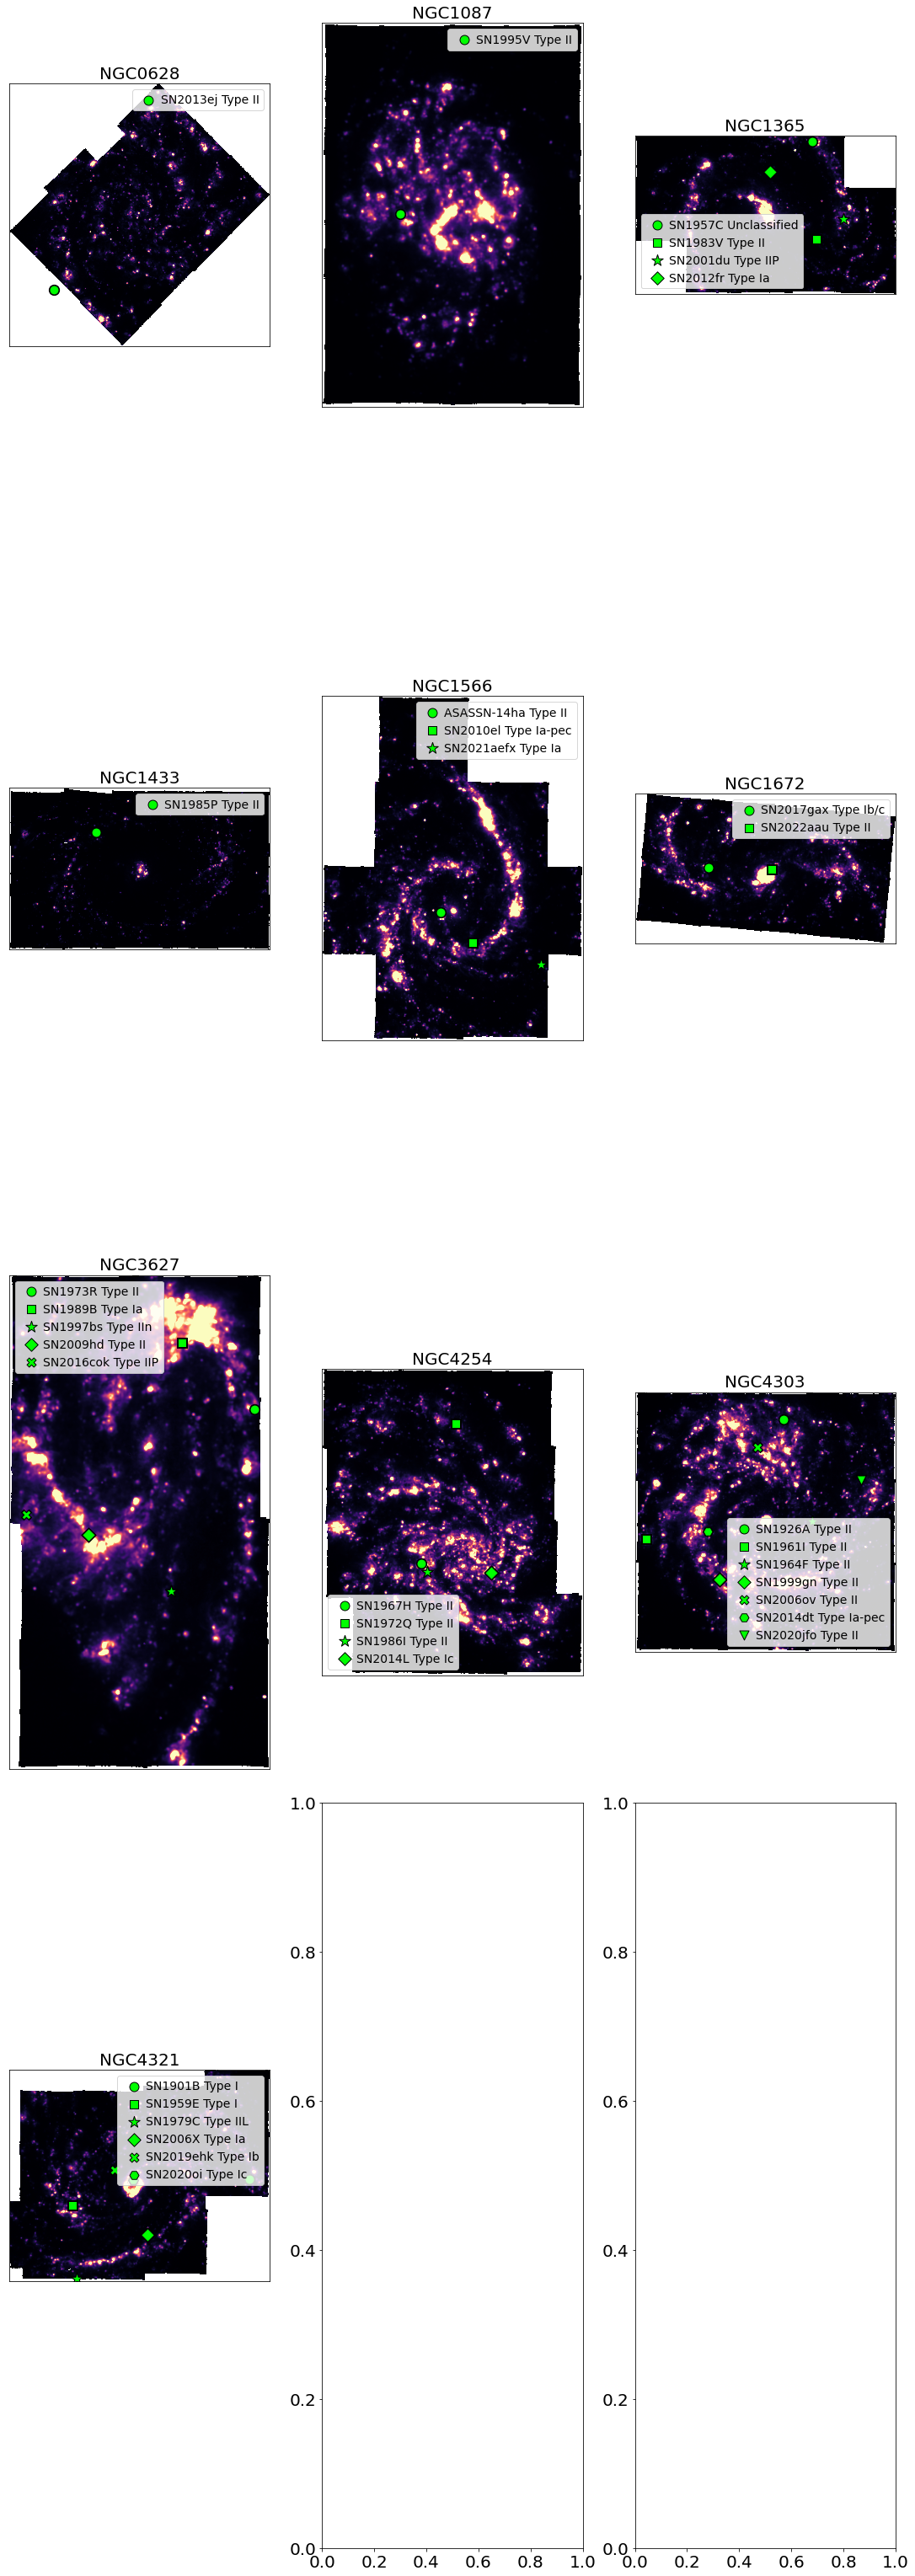

In [16]:
from matplotlib.patches import Circle


markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
markerSizes  = [120,120,200,120,120,120,120]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("white")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15, 45))
for plot in plots:

    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    logplot = np.log10(plot)
    axs[i][j].imshow(plot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest",
                    vmin=-0.1, vmax=10000)
    axs[i][j].set_title(SNgals[m].upper(), fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="black", label = legendLabels[m][n])
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/AllSNeInGalaxies.png", dpi=300)
   

print()

In [17]:
# remove 0628 and remake figure because SN is outside of footprint

plots.pop(0)
wcss.pop(0)
SNgals.pop(0)
ras.pop(0)
decs.pop(0)
legendLabels.pop(0)

['SN2013ej Type II']

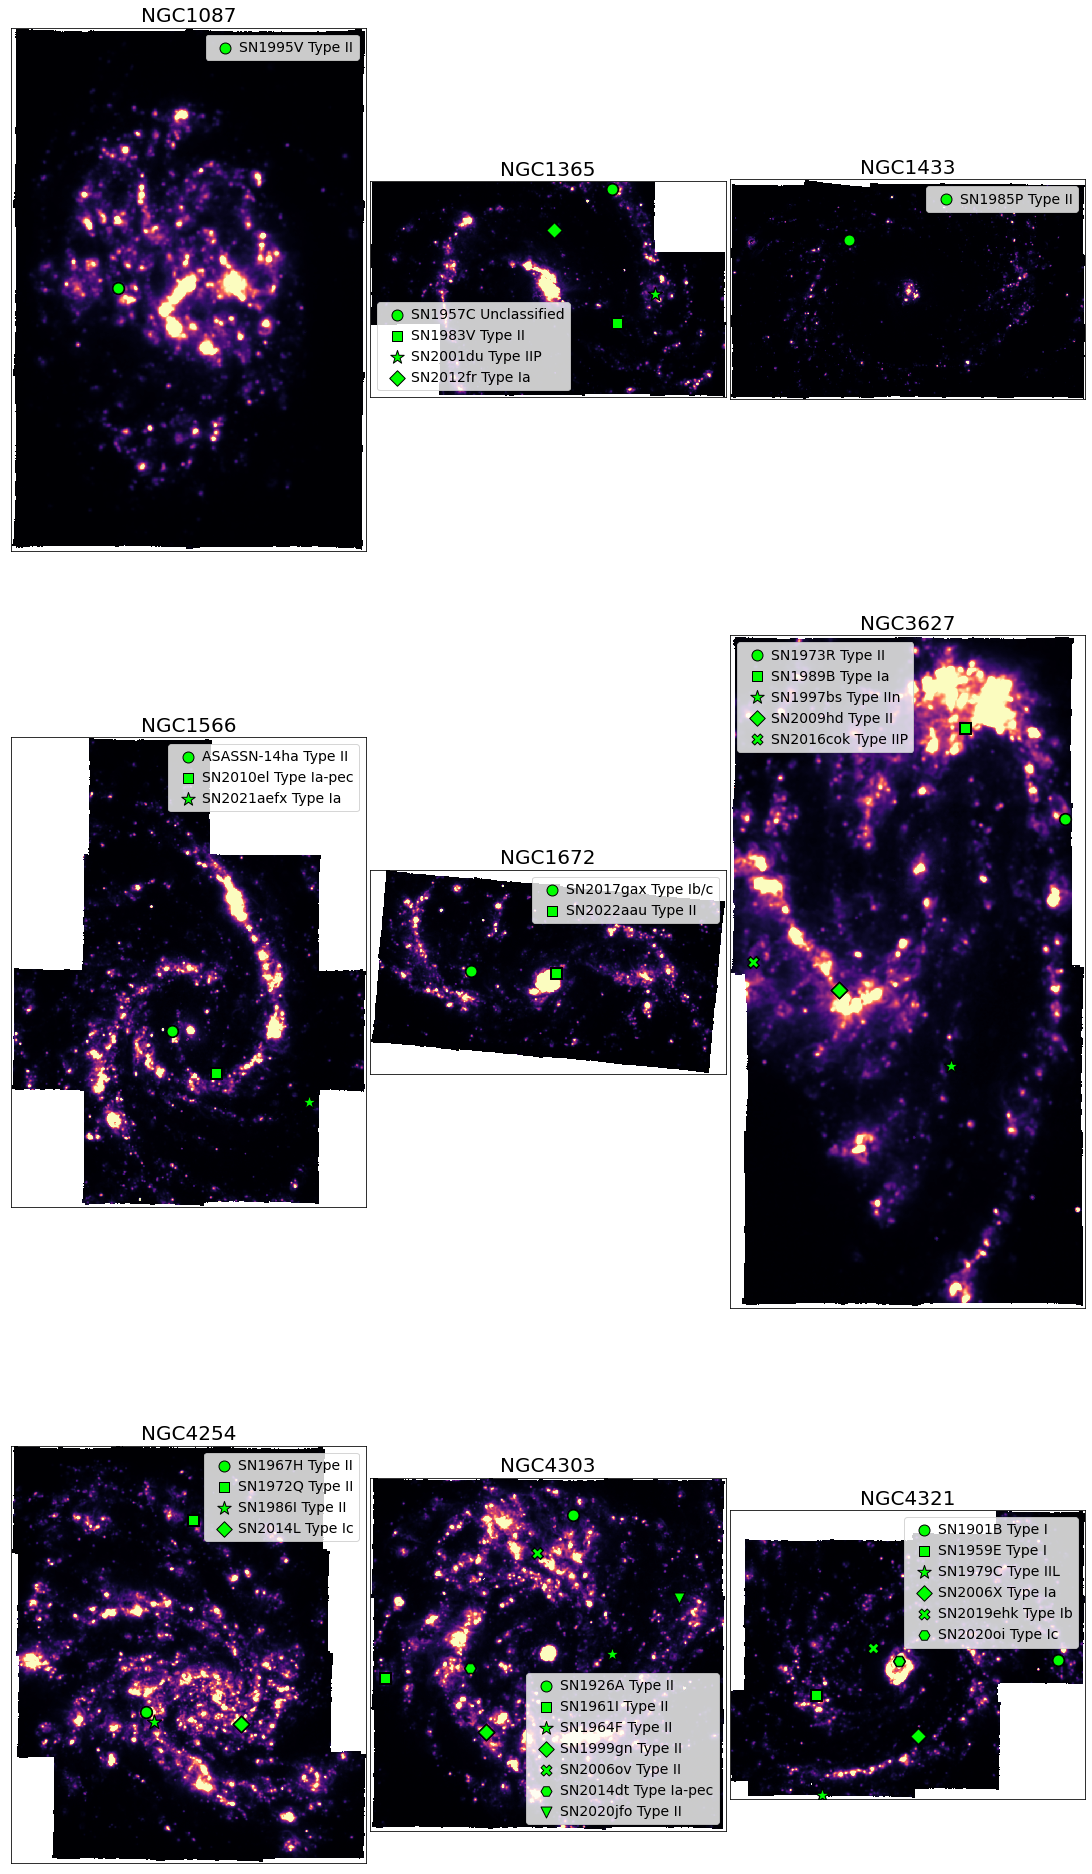

In [23]:


from matplotlib.patches import Circle


markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
markerSizes  = [120,120,200,120,120,120,120]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("white")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15, 30))
for plot in plots:

    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    logplot = np.log10(plot)
    axs[i][j].imshow(plot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest",
                    vmin=-0.9, vmax=10000)
    axs[i][j].set_title(SNgals[m].upper(), fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="black", label = legendLabels[m][n])
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/AllSNeInGalaxies.png", dpi=300)
 